## Neural Network Implementation

Importing required packages

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report

2023-05-07 12:05:12.042883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Importing Dataset and exploring the labels.

In [31]:
df = pd.read_csv('NTSB_baseline_for_model_unbalanced.csv', low_memory=False)
pd.set_option('display.max_rows', 100)
df.dtypes

Unnamed: 0                 int64
flight_plan_activated      int64
acft_make                  int64
acft_model                 int64
cert_max_gr_wt             int64
num_eng                    int64
type_last_insp             int64
date_last_insp             int64
afm_hrs_last_insp        float64
afm_hrs                    int64
type_fly                   int64
dprt_apt_id                int64
dprt_city                  int64
dprt_state                 int64
dprt_time                  int64
dest_same_local            int64
dest_apt_id                int64
dest_city                  int64
dest_state                 int64
afm_hrs_since              int64
rwy_num                    int64
rwy_len                  float64
rwy_width                float64
ifr_equipped_cert           bool
eng_no                   float64
eng_type                   int64
eng_mfgr                   int64
eng_time_total           float64
eng_time_last_insp       float64
ev_date                    int64
ev_dow    

In [32]:
#Dropping columns. wx_obs_fac_id used for joining with weather data, needed for analysis? last two for class, not needed for model?
df = df.drop(['ev_date', 'ev_city', 'ev_state', 'date_last_insp', 'dest_same_local', 'dest_apt_id', 'dest_city',  'dest_state', 'ev_time', 
             'flight_plan_activated', 'eng_time_total', 'eng_time_last_insp', 'latitude', 
              'longitude','wx_dens_alt','crew_no', 'crew_sex', 'crew_age','afm_hrs_since'], axis=1)

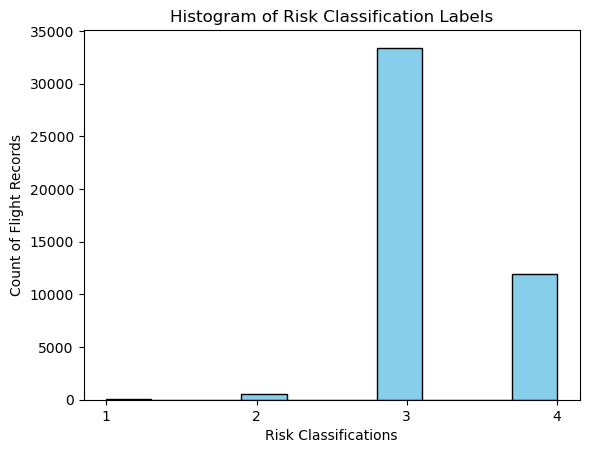

In [4]:
# Plotting a histogram of the risk classificiation labels
plt.hist(df['target'], color='skyblue', edgecolor='black')
plt.xlabel('Risk Classifications')
plt.ylabel('Count of Flight Records')
plt.title('Histogram of Risk Classification Labels')
plt.xticks(range(int(df['target'].min()), int(df['target'].max())+1))
plt.show()

### Balancing the Dataset

In [5]:
df['target'].value_counts()

3    33403
4    11968
2      589
1       92
Name: target, dtype: int64

In [33]:
# Split the data into features (X) and target variable (y)
X = df.drop('target', axis=1)
y = df['target']

# Calculate the class distribution
class_counts = y.value_counts().to_dict()

# Define the desired target counts for each class
target_counts = {
    1: class_counts.get(1, 0) + 10000,  # Oversample class 1 (increase by 10000)
    2: class_counts.get(2, 0) + 10000,  # Oversample class 2 (increase by 10000)
    3: class_counts.get(3, 0) // 3,     # Undersample class 3 (a third of the original count)
    4: class_counts.get(4, 0) // 1      # Keep the same )
}

# Creating the pipeline to implement the sampling strategy
pipeline = make_pipeline(
    RandomUnderSampler(sampling_strategy={3: target_counts[3], 4: target_counts[4]}),
    RandomOverSampler(sampling_strategy={1: target_counts[1], 2: target_counts[2]})
)

# Perform the combined sampling
X_resampled, y_resampled = pipeline.fit_resample(X, y)


# Create a new DataFrame with the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['target'] = y_resampled

# Verify the class distribution after sampling
resampled_df['target'].value_counts()

4    11968
3    11134
2    10589
1    10092
Name: target, dtype: int64

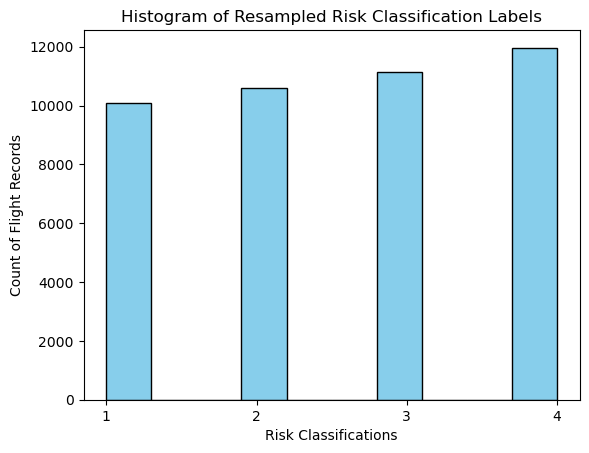

In [7]:
# Histogram of the adjusted dataset
plt.hist(resampled_df['target'], color='skyblue', edgecolor='black')
plt.xlabel('Risk Classifications')
plt.ylabel('Count of Flight Records')
plt.title('Histogram of Resampled Risk Classification Labels')
plt.xticks(range(int(resampled_df['target'].min()), int(resampled_df['target'].max())+1))
plt.show()

# Initiating NN - using unbalanced dataset

In [36]:

# Split the data into features (X) and target variable (y)
X = df.drop('target', axis=1)
y = df['target']

# Perform multiple imputation
imputer = IterativeImputer()
X_imputed = imputer.fit_transform(X)

# Create a new DataFrame with imputed values
columns = X.columns
df_imputed1 = pd.DataFrame(X_imputed, columns=columns)

# Add the target column back to the imputed DataFrame
df_imputed1['target'] = y


In [37]:
#Shuffling the data prior to splitting for train/test/val sets
df_imputed1_shuffled = df_imputed1.sample(frac=1).reset_index()

Epoch 1/10
921/921 [==============================] - 1s 1ms/step - loss: 107.9068 - accuracy: 0.6108 - val_loss: 54.4410 - val_accuracy: 0.5257
Epoch 2/10
921/921 [==============================] - 1s 1ms/step - loss: 61.7042 - accuracy: 0.6212 - val_loss: 39.5327 - val_accuracy: 0.6488
Epoch 3/10
921/921 [==============================] - 1s 1ms/step - loss: 45.1939 - accuracy: 0.6236 - val_loss: 29.4741 - val_accuracy: 0.7029
Epoch 4/10
921/921 [==============================] - 1s 1ms/step - loss: 36.2537 - accuracy: 0.6276 - val_loss: 33.1532 - val_accuracy: 0.7023
Epoch 5/10
921/921 [==============================] - 1s 998us/step - loss: 34.6899 - accuracy: 0.6239 - val_loss: 18.7237 - val_accuracy: 0.6934
Epoch 6/10
921/921 [==============================] - 1s 1ms/step - loss: 26.1341 - accuracy: 0.6277 - val_loss: 39.1910 - val_accuracy: 0.7013
Epoch 7/10
921/921 [==============================] - 1s 1ms/step - loss: 23.6992 - accuracy: 0.6249 - val_loss: 38.6704 - val_accura

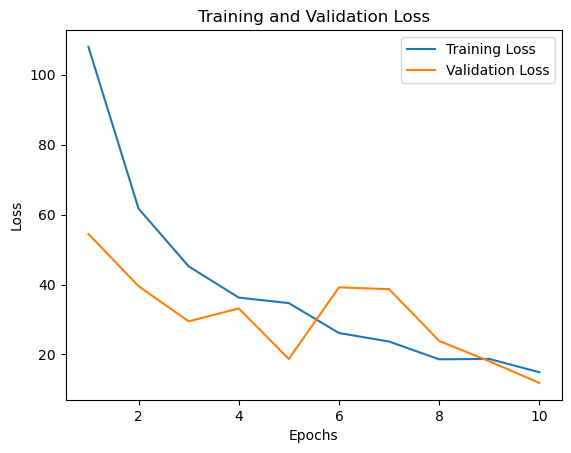

In [28]:
# Split the data into features (X) and target variable (y)
X = df_imputed1_shuffled.drop('target', axis=1)
y = df_imputed1_shuffled['target']

# Train-test split using a stratified method as this experiment is with the unbalanced dataset

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Perform stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


# Convert the target variables to categorical
num_classes = df_imputed['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model1 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
#model1.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)
# Train the model
history = model1.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model1.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)

# Get the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the last recorded loss values
print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])
print("Test accuracy:", accuracy)

# Plot the training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

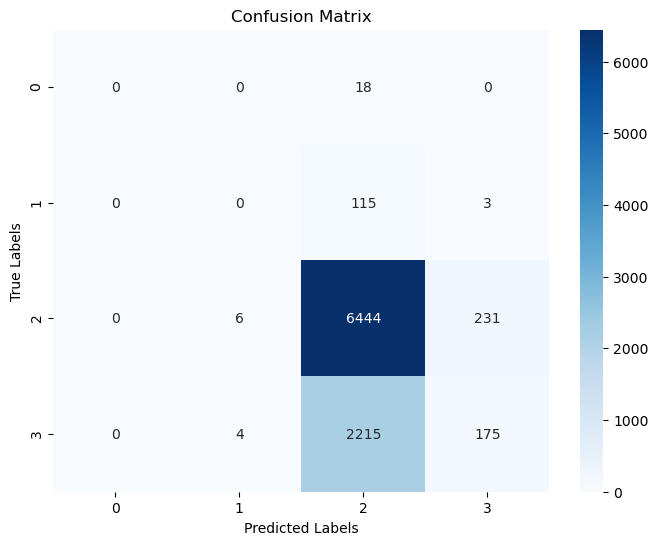

In [23]:
# Calculate the confusion matrix
cm1 = confusion_matrix(y_test_labels, y_pred_labels)  # Add 1 to adjust class labels

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
from sklearn.metrics import classification_report

# Generate the classification report
classification_report1 = classification_report(y_test_labels, y_pred_labels)

print(classification_report1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00       118
           2       0.78      0.64      0.70      6681
           3       0.34      0.53      0.42      2394

    accuracy                           0.60      9211
   macro avg       0.28      0.29      0.28      9211
weighted avg       0.66      0.60      0.62      9211



## NN with data imputed by class first

In [41]:
# Split the data into features (X) and target variable (y)
X = df.drop('target', axis=1)
y = df['target']

# Initialize an empty DataFrame for imputed data
df_imputed2 = pd.DataFrame()

# Iterate over unique target classes
for class_value in y.unique():
    # Split data for the current class
    X_class = X[y == class_value]
    
    # Perform imputation on the current class
    imputer = IterativeImputer(max_iter=10, tol=0.001)
    X_class_imputed = imputer.fit_transform(X_class)
    
    # Concatenate the imputed data for the current class
    df_imputed2 = pd.concat([df_imputed2, pd.DataFrame(X_class_imputed, columns=X.columns)])
    
# Add the target column back to the imputed DataFrame
df_imputed2['target'] = y
print(df_imputed2.isnull().sum())

/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Unnamed: 0           0
acft_make            0
acft_model           0
cert_max_gr_wt       0
num_eng              0
type_last_insp       0
afm_hrs_last_insp    0
afm_hrs              0
type_fly             0
dprt_apt_id          0
dprt_city            0
dprt_state           0
dprt_time            0
rwy_num              0
rwy_len              0
rwy_width            0
ifr_equipped_cert    0
eng_no               0
eng_type             0
eng_mfgr             0
ev_dow               0
ev_month             0
apt_name             0
apt_elev             0
wx_obs_time          0
light_cond           0
sky_cond_nonceil     0
sky_nonceil_ht       0
sky_ceil_ht          0
sky_cond_ceil        0
vis_rvr              0
vis_sm               0
wx_temp              0
wx_dew_pt            0
wind_dir_deg         0
wind_dir_ind         0
wind_vel_kts         0
gust_kts             0
altimeter            0
wx_int_precip        0
wx_cond_basic        0
ACTU                 0
ALL                  0
MAKE       

In [42]:
#Shuffling the data prior to splitting for train/test/val sets
df_imputed2_shuffled = df_imputed2.sample(frac=1).reset_index()

Epoch 1/10
921/921 [==============================] - 1s 1ms/step - loss: 89.6592 - accuracy: 0.5757 - val_loss: 75.9781 - val_accuracy: 0.6565
Epoch 2/10
921/921 [==============================] - 1s 970us/step - loss: 30.6598 - accuracy: 0.5794 - val_loss: 121.4215 - val_accuracy: 0.6610
Epoch 3/10
921/921 [==============================] - 1s 970us/step - loss: 23.7950 - accuracy: 0.5822 - val_loss: 50.3292 - val_accuracy: 0.6784
Epoch 4/10
921/921 [==============================] - 1s 984us/step - loss: 17.0749 - accuracy: 0.5838 - val_loss: 10.3164 - val_accuracy: 0.5025
Epoch 5/10
921/921 [==============================] - 1s 975us/step - loss: 13.7251 - accuracy: 0.5850 - val_loss: 31.9695 - val_accuracy: 0.6850
Epoch 6/10
921/921 [==============================] - 1s 973us/step - loss: 10.6332 - accuracy: 0.5872 - val_loss: 76.7137 - val_accuracy: 0.6910
Epoch 7/10
921/921 [==============================] - 1s 989us/step - loss: 8.3000 - accuracy: 0.5844 - val_loss: 8.4764 - va

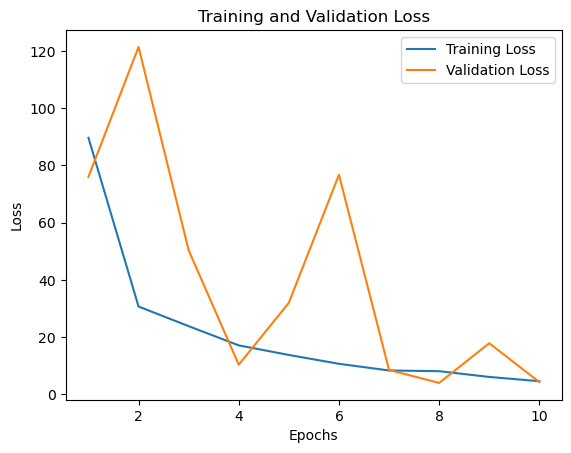

In [43]:
# Split the data into features (X) and target variable (y)
X = df_imputed2_shuffled.drop('target', axis=1)
y = df_imputed2_shuffled['target']

# Train-test split using a stratified method as this experiment is with the unbalanced dataset

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Perform stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


# Convert the target variables to categorical
num_classes = df_imputed['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
#model1.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)
# Train the model
history = model2.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model2.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)

# Get the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the last recorded loss values
print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])
print("Test accuracy:", accuracy)

# Plot the training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

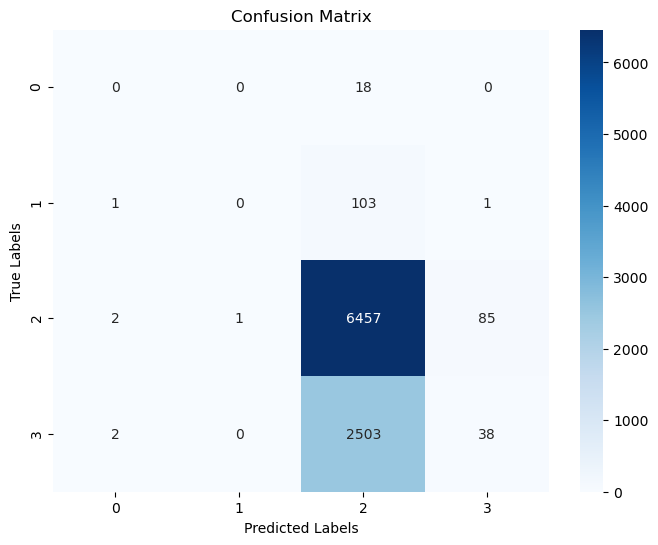

In [45]:
# Calculate the confusion matrix
cm2 = confusion_matrix(y_test_labels + 1, y_pred_labels + 1)  # Add 1 to adjust class labels

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:


# Generate the classification report
classification_report2 = classification_report(y_test_labels, y_pred_labels)

print(classification_report2)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00       105
           2       0.71      0.99      0.83      6545
           3       0.31      0.01      0.03      2543

    accuracy                           0.71      9211
   macro avg       0.25      0.25      0.21      9211
weighted avg       0.59      0.71      0.60      9211



## NN Using Resampled Data

In [5]:
# Split the data into features (X) and target variable (y)
X = resampled_df.drop('target', axis=1)
y = resampled_df['target']

# Initialize an empty DataFrame for imputed data
df_imputed3 = pd.DataFrame()

# Iterate over unique target classes
for class_value in y.unique():
    # Split data for the current class
    X_class = X[y == class_value]
    
    # Perform imputation on the current class
    imputer = IterativeImputer()
    X_class_imputed = imputer.fit_transform(X_class)
    
    # Concatenate the imputed data for the current class
    df_imputed3 = pd.concat([df_imputed3, pd.DataFrame(X_class_imputed, columns=X.columns)])
    
# Add the target column back to the imputed DataFrame
df_imputed3['target'] = y

# Verify if the imputation is successful
print(df_imputed3.isnull().sum())

/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Unnamed: 0           0
acft_make            0
acft_model           0
cert_max_gr_wt       0
num_eng              0
type_last_insp       0
afm_hrs_last_insp    0
afm_hrs              0
type_fly             0
dprt_apt_id          0
dprt_city            0
dprt_state           0
dprt_time            0
rwy_num              0
rwy_len              0
rwy_width            0
ifr_equipped_cert    0
eng_no               0
eng_type             0
eng_mfgr             0
ev_dow               0
ev_month             0
apt_name             0
apt_elev             0
wx_obs_time          0
light_cond           0
sky_cond_nonceil     0
sky_nonceil_ht       0
sky_ceil_ht          0
sky_cond_ceil        0
vis_rvr              0
vis_sm               0
wx_temp              0
wx_dew_pt            0
wind_dir_deg         0
wind_dir_ind         0
wind_vel_kts         0
gust_kts             0
altimeter            0
wx_int_precip        0
wx_cond_basic        0
ACTU                 0
ALL                  0
MAKE       

/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
#Shuffling the data prior to splitting for train/test/val sets
df_imputed3_shuffled = df_imputed3.sample(frac=1).reset_index()

Epoch 1/10
876/876 [==============================] - 1s 1ms/step - loss: 3839812968644608.0000 - accuracy: 0.8976 - val_loss: 4407838231232512.0000 - val_accuracy: 0.8349
Epoch 2/10
876/876 [==============================] - 1s 1ms/step - loss: 1883100896296960.0000 - accuracy: 0.9227 - val_loss: 768807870136320.0000 - val_accuracy: 0.9415
Epoch 3/10
876/876 [==============================] - 1s 1ms/step - loss: 2015696334618624.0000 - accuracy: 0.9304 - val_loss: 986499629711360.0000 - val_accuracy: 0.9395
Epoch 4/10
876/876 [==============================] - 1s 1ms/step - loss: 1098167571447808.0000 - accuracy: 0.9360 - val_loss: 1166209114439680.0000 - val_accuracy: 0.9612
Epoch 5/10
876/876 [==============================] - 1s 1ms/step - loss: 1072599899570176.0000 - accuracy: 0.9380 - val_loss: 857077635350528.0000 - val_accuracy: 0.9432
Epoch 6/10
876/876 [==============================] - 1s 1ms/step - loss: 549763229417472.0000 - accuracy: 0.9423 - val_loss: 118433949679616.0

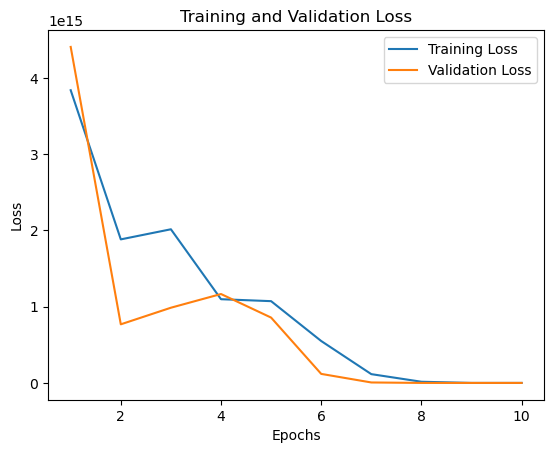

In [51]:
#Shuffling the data prior to splitting for train/test/val sets
df_imputed3_shuffled = df_imputed3.sample(frac=1).reset_index()

# Split the data into features (X) and target variable (y)
X = df_imputed3_shuffled.drop('target', axis=1)
y = df_imputed3_shuffled['target']

# Train-test split using a stratified method as this experiment is with the unbalanced dataset

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Perform stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


# Convert the target variables to categorical
num_classes = df_imputed3_shuffled['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
#model1.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)
# Train the model
history = model2.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model2.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)

# Get the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the last recorded loss values
print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])
print("Test accuracy:", accuracy)

# Plot the training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

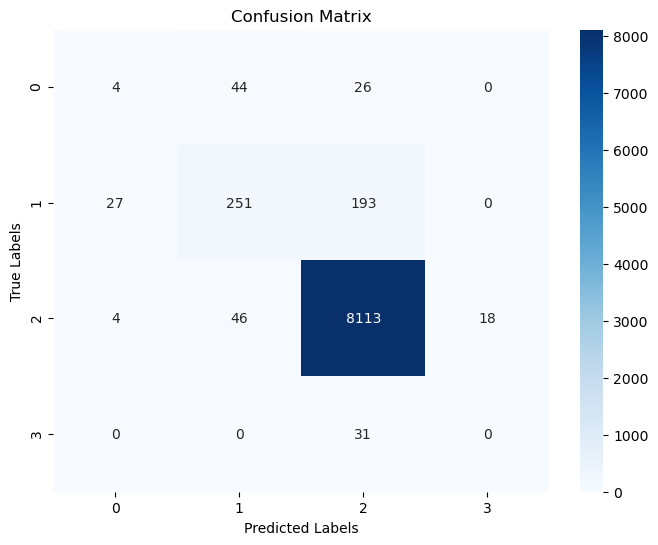

In [52]:
# Calculate the confusion matrix
cm3 = confusion_matrix(y_test_labels, y_pred_labels)  # Add 1 to adjust class labels

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:


# Generate the classification report
classification_report3 = classification_report(y_test_labels, y_pred_labels)

print(classification_report3)

              precision    recall  f1-score   support

           0       0.11      0.05      0.07        74
           1       0.74      0.53      0.62       471
           2       0.97      0.99      0.98      8181
           3       0.00      0.00      0.00        31

    accuracy                           0.96      8757
   macro avg       0.46      0.39      0.42      8757
weighted avg       0.95      0.96      0.95      8757



In [ ]:
sci kit learn feature importance 

In [ ]:
hyperparameter tuning?

### 10 Fold Cross-Validation with final model. 


In [58]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# Split the data into features (X) and target variable (y)
X = df_imputed3_shuffled.drop('target', axis=1)
y = df_imputed3_shuffled['target']


# Define a function that returns the Keras model
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create a KerasClassifier with the model function
model = KerasClassifier(build_fn=create_model, epochs=10)

# Perform 10-fold cross-validation
scores = cross_val_score(model, X, y_categorical, cv=10)

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Average Score:", scores.mean())
print("Standard Deviation:", scores.std())

Epoch 1/10


/var/folders/65/bth0h0g92jx2t6br_rg9mxhh0000gn/T/ipykernel_11261/792258838.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10)


1232/1232 [==============================] - 2s 922us/step - loss: 5323820269305856.0000 - accuracy: 0.9038
Epoch 2/10
1232/1232 [==============================] - 1s 898us/step - loss: 3005564426649600.0000 - accuracy: 0.9327
Epoch 3/10
1232/1232 [==============================] - 1s 961us/step - loss: 1662307365027840.0000 - accuracy: 0.9399
Epoch 4/10
1232/1232 [==============================] - 1s 887us/step - loss: 1036122876542976.0000 - accuracy: 0.9426
Epoch 5/10
1232/1232 [==============================] - 1s 862us/step - loss: 558581871017984.0000 - accuracy: 0.9411
Epoch 6/10
1232/1232 [==============================] - 1s 896us/step - loss: 417868172754944.0000 - accuracy: 0.9512
Epoch 7/10
1232/1232 [==============================] - 1s 973us/step - loss: 241158638796800.0000 - accuracy: 0.9513
Epoch 8/10
1232/1232 [==============================] - 1s 1ms/step - loss: 287714792439808.0000 - accuracy: 0.9533
Epoch 9/10
1232/1232 [==============================] - 1s 904us/

1232/1232 [==============================] - 1s 839us/step - loss: 564203211456512.0000 - accuracy: 0.9278
Epoch 6/10
1232/1232 [==============================] - 1s 824us/step - loss: 336722315444224.0000 - accuracy: 0.9235
Epoch 7/10
1232/1232 [==============================] - 1s 857us/step - loss: 148192779829248.0000 - accuracy: 0.8807
Epoch 8/10
1232/1232 [==============================] - 1s 863us/step - loss: 2.4166 - accuracy: 0.9328
Epoch 9/10
1232/1232 [==============================] - 1s 885us/step - loss: 1.8297 - accuracy: 0.9333
Epoch 10/10
137/137 [==============================] - 0s 920us/step - loss: 1.2458 - accuracy: 0.9413
Epoch 1/10
1232/1232 [==============================] - 2s 921us/step - loss: 6126636630016000.0000 - accuracy: 0.9076
Epoch 2/10
1232/1232 [==============================] - 1s 968us/step - loss: 3845392936468480.0000 - accuracy: 0.9347
Epoch 3/10
1232/1232 [==============================] - 1s 977us/step - loss: 3445795353264128.0000 - accura

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with

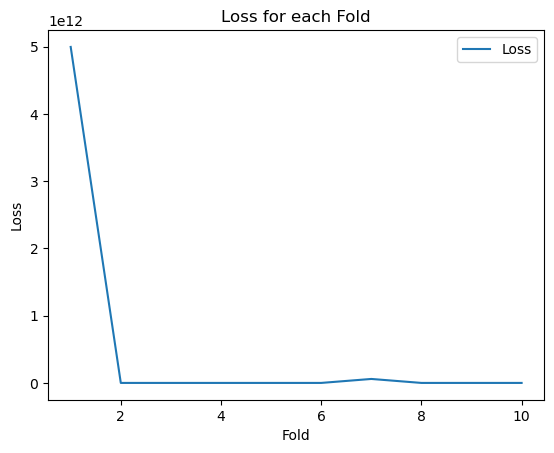

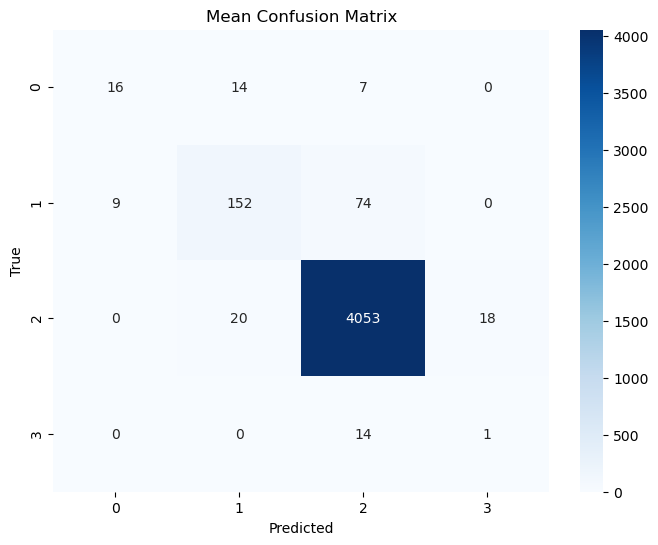

In [76]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Split the data into features (X) and target variable (y)
X = df_imputed3_shuffled.drop('target', axis=1)
y = df_imputed3_shuffled['target']

# Convert the target variable to categorical
num_classes = df_imputed3_shuffled['target'].nunique()
y_categorical = keras.utils.to_categorical(y - 1, num_classes=num_classes)

# Define your model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Perform 10-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
loss_values = []
accuracy_values = []
confusion_matrices = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, verbose=0)

    # Evaluate the model on the test data
    y_pred_categorical = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_categorical, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_labels == y_true_labels)

    # Get the loss value from the history
    loss = history.history['loss'][-1]

    loss_values.append(loss)
    accuracy_values.append(accuracy)
    confusion_matrices.append(confusion_matrix(y_true_labels, y_pred_labels))

# Calculate the mean and standard deviation of loss and accuracy
mean_loss = np.mean(loss_values)
std_loss = np.std(loss_values)
mean_accuracy = np.mean(accuracy_values)
std_accuracy = np.std(accuracy_values)

# Print the mean and standard deviation of loss and accuracy
print("Mean Loss:", mean_loss)
print("Standard Deviation of Loss:", std_loss)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

# Plot the loss values
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Loss for each Fold')
plt.legend()
plt.show()

# Plot the confusion matrix
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_confusion_matrix, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mean Confusion Matrix')
plt.show()


To obtain classification reports:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with

/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 680us/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 711us/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 705us/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 645us/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 704us/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 834us/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 802us/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 1ms/step


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

137/137 [==============================] - 0s 751us/step
Mean Loss: 336452360601.79895
Standard Deviation of Loss: 1009357081804.7336
Mean Accuracy: 0.9341753923137663
Standard Deviation of Accuracy: 0.0003882217476206344


/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenhill/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

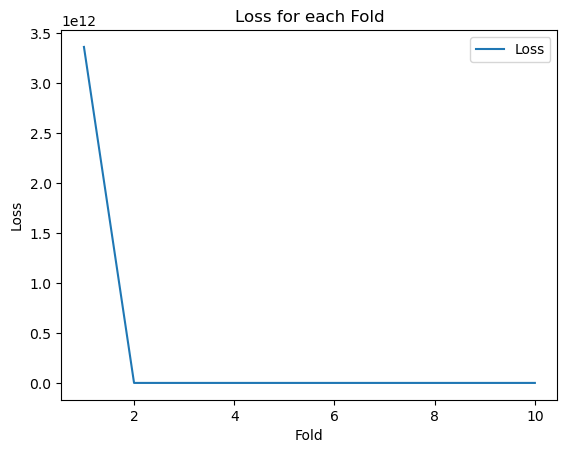

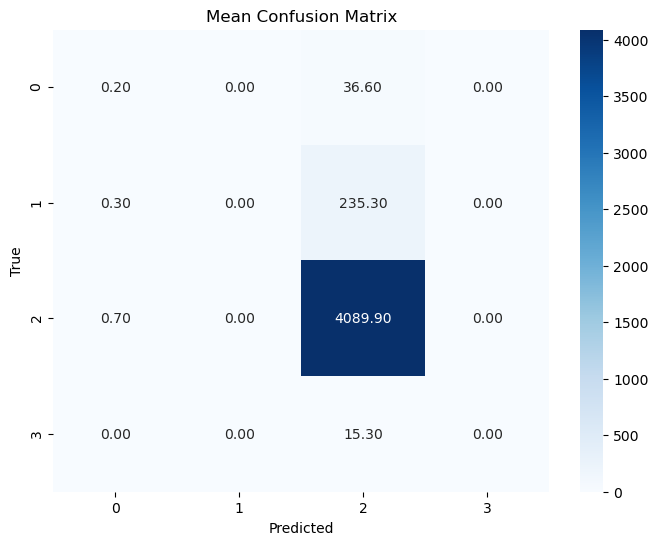

Classification Report - Fold 1
              precision    recall  f1-score   support

           0       0.17      0.05      0.08        37
           1       0.00      0.00      0.00       236
           2       0.94      1.00      0.97      4091
           3       0.00      0.00      0.00        15

    accuracy                           0.93      4379
   macro avg       0.28      0.26      0.26      4379
weighted avg       0.88      0.93      0.90      4379

--------------------------------------------------
Classification Report - Fold 2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00       236
           2       0.93      1.00      0.97      4091
           3       0.00      0.00      0.00        15

    accuracy                           0.93      4379
   macro avg       0.23      0.25      0.24      4379
weighted avg       0.87      0.93      0.90      4379

-----------------

In [69]:

# Split the data into features (X) and target variable (y)
X = df_imputed3_shuffled.drop('target', axis=1)
y = df_imputed3_shuffled['target']

# Convert the target variable to categorical
num_classes = df_imputed3_shuffled['target'].nunique()
y_categorical = keras.utils.to_categorical(y - 1, num_classes=num_classes)

# Define your model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Perform 10-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
loss_values = []
accuracy_values = []
confusion_matrices = []
classification_reports = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, verbose=0)

    # Evaluate the model on the test data
    y_pred_categorical = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_categorical, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_labels == y_true_labels)

    # Get the loss value from the history
    loss = history.history['loss'][-1]

    loss_values.append(loss)
    accuracy_values.append(accuracy)
    confusion_matrices.append(confusion_matrix(y_true_labels, y_pred_labels))
    classification_reports.append(classification_report(y_true_labels, y_pred_labels))

# Calculate the mean and standard deviation of loss and accuracy
mean_loss = np.mean(loss_values)
std_loss = np.std(loss_values)
mean_accuracy = np.mean(accuracy_values)
std_accuracy = np.std(accuracy_values)

# Print the mean and standard deviation of loss and accuracy
print("Mean Loss:", mean_loss)
print("Standard Deviation of Loss:", std_loss)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

# Plot the loss values
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Loss for each Fold')
plt.legend()
plt.show()

# Plot the confusion matrix
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_confusion_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mean Confusion Matrix')
plt.show()

# Print the classification reports for each fold
for i, report in enumerate(classification_reports):
    print(f"Classification Report - Fold {i+1}")
    print(report)
    print("-" * 50)

In [74]:
# Combine the classification reports into a single DataFrame
classification_reports_df = pd.DataFrame(classification_reports, columns=['classification_report'])

# Initialize an empty dictionary to store label-wise precision, recall, and F1-score
label_scores = {}

# Extract precision, recall, and F1-score for each label from the classification reports
for report in classification_reports_df['classification_report']:
    report_lines = report.strip().split('\n')
    label = report_lines[0].split()[-1]
    label_values = report_lines[2].split()[1:5]
    precision = float(label_values[0])
    recall = float(label_values[1])
    f1_score = float(label_values[2])
    
    # Store the scores for the current label in the dictionary
    label_scores[label] = {'Precision': precision, 'Recall': recall, 'F1-score': f1_score}

# Create a DataFrame from the label scores dictionary
summary_table = pd.DataFrame(label_scores).T
summary_table.index.name = 'Label'

# Print the summary table
print(summary_table)

         F1-score  Precision  Recall
Label                               
support       0.0        0.0     0.0


### Hypertuning

In [26]:
from sklearn.model_selection import GridSearchCV
from tensorflow import keras

# Split the data into features (X) and target variable (y)
X = df_imputed3_shuffled.drop('target', axis=1)
y = df_imputed3_shuffled['target']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert the target variable to categorical
num_classes = df_imputed3_shuffled['target'].nunique()
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)

# Define your model
def create_model(activation='relu', optimizer='adam'):
    model = keras.Sequential([
        keras.layers.Dense(64, activation=activation, input_shape=(X_train.shape[1],)),
        keras.layers.Dense(32, activation=activation),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the hyperparameters to tune
param_grid = {
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'sgd']
}

# Create the model
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train_categorical)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

/var/folders/65/bth0h0g92jx2t6br_rg9mxhh0000gn/T/ipykernel_13454/737640373.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.au

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.au

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with

Rerunning the NN with optimized parameters:

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
874/876 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.9343WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f83682bd040> and will run it as-is.
Please report this to the TensorFlow team. When filing t

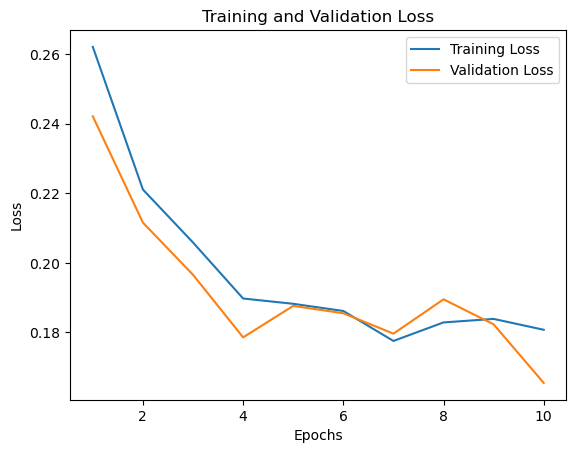

In [66]:
# Split the data into features (X) and target variable (y)
X = df_imputed3_shuffled.drop('target', axis=1)
y = df_imputed3_shuffled['target']

# Train-test split using a stratified method as this experiment is with the unbalanced dataset

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Perform stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


# Convert the target variables to categorical
num_classes = df_imputed3_shuffled['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model2 = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dense(num_classes, activation='sigmoid')
])

# Compile your model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
#model1.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)
# Train the model
history = model2.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model2.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)

# Get the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the last recorded loss values
print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])
print("Test accuracy:", accuracy)

# Plot the training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Obtaining feature importance for final model.

1. Feature: index, Importance: 17.29970359802246
2. Feature: rwy_len, Importance: 9.616127967834473
3. Feature: ACTU, Importance: 9.160781860351562
4. Feature: dprt_city, Importance: 9.108138084411621
5. Feature: SIMU, Importance: 8.914335250854492
6. Feature: type_last_insp, Importance: 8.701417922973633
7. Feature: altimeter, Importance: 8.6582670211792
8. Feature: wx_dew_pt, Importance: 8.615995407104492
9. Feature: afm_hrs_last_insp, Importance: 8.613870620727539
10. Feature: eng_no, Importance: 8.595199584960938
11. Feature: eng_mfgr, Importance: 8.558023452758789
12. Feature: MAKE, Importance: 8.550411224365234
13. Feature: wx_cond_basic, Importance: 8.482156753540039
14. Feature: ev_dow, Importance: 8.45602798461914
15. Feature: wx_obs_time, Importance: 8.446962356567383
16. Feature: ev_month, Importance: 8.413344383239746
17. Feature: dprt_time, Importance: 8.389456748962402
18. Feature: light_cond, Importance: 8.327642440795898
19. Feature: gust_kts, Importance: 8.311130523681

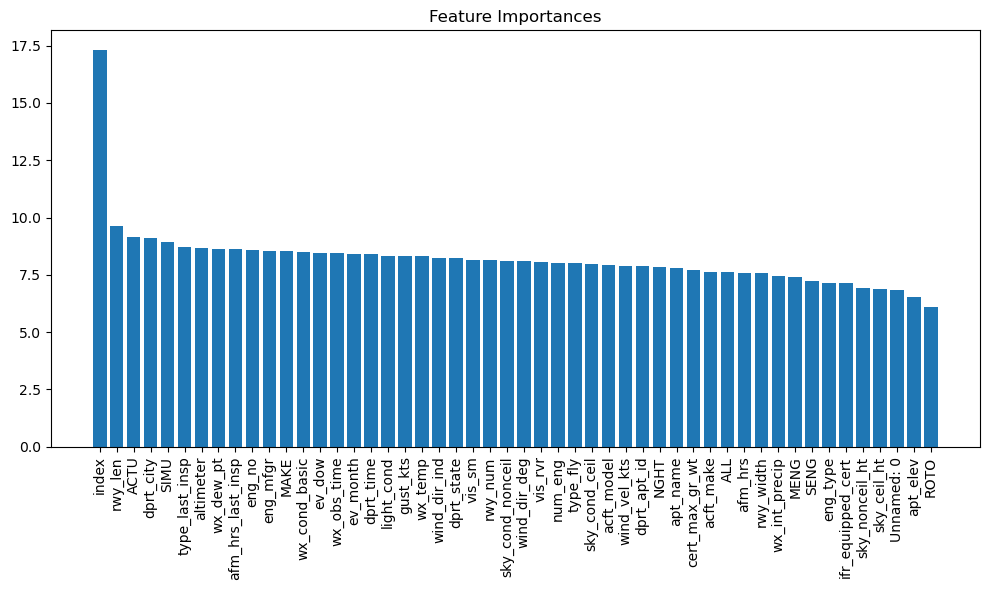

In [29]:
# Get the weights of the neural network
weights = model2.get_weights()

# Calculate the absolute sum of weights for each feature
feature_importances = np.sum(np.abs(weights[0]), axis=1)

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature importance rankings
for i in range(len(feature_importances)):
    print(f"{i + 1}. Feature: {X.columns[indices[i]]}, Importance: {feature_importances[indices[i]]}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
#Dropping index and rerunning analysis

In [44]:
resampled_df_no_index = df_imputed3.drop("Unnamed: 0", axis=1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
866/876 [============================>.] - ETA: 0s - loss: 1105832209022976.0000 - accuracy: 0.8937WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f83c347ae50> and will run it as-is.
Please report this to the TensorFlow team

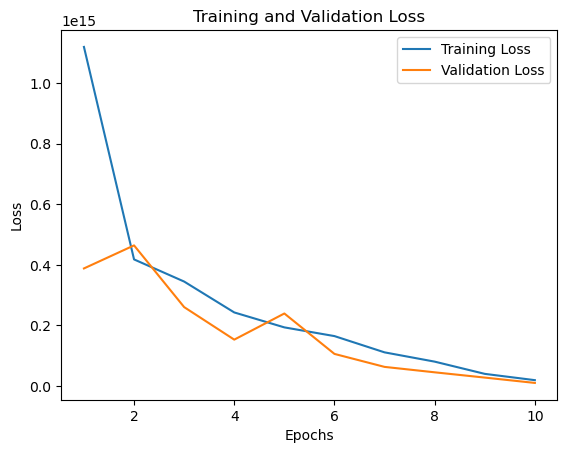

In [50]:
#Shuffling the data prior to splitting for train/test/val sets
resampled_df_no_index_shuffled = resampled_df_no_index.sample(frac=1).reset_index()

# Split the data into features (X) and target variable (y)
X = resampled_df_no_index_shuffled.drop('target', axis=1)
y = resampled_df_no_index_shuffled['target']

# Train-test split using a stratified method as this experiment is with the unbalanced dataset

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Perform stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


# Convert the target variables to categorical
num_classes = resampled_df_no_index_shuffled['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model3 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
#model1.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)
# Train the model
history = model3.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model3.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)

y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)

# Get the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the last recorded loss values
print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])
print("Test accuracy:", accuracy)

# Plot the training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

1. Feature: index, Importance: 22.74302864074707
2. Feature: acft_model, Importance: 12.843091011047363
3. Feature: vis_sm, Importance: 12.735847473144531
4. Feature: altimeter, Importance: 11.942331314086914
5. Feature: dprt_time, Importance: 11.304075241088867
6. Feature: ifr_equipped_cert, Importance: 10.970403671264648
7. Feature: eng_no, Importance: 10.734468460083008
8. Feature: eng_mfgr, Importance: 10.674022674560547
9. Feature: ev_dow, Importance: 10.328065872192383
10. Feature: cert_max_gr_wt, Importance: 10.287797927856445
11. Feature: afm_hrs, Importance: 10.14599609375
12. Feature: gust_kts, Importance: 10.127105712890625
13. Feature: vis_rvr, Importance: 10.118715286254883
14. Feature: eng_type, Importance: 10.016119003295898
15. Feature: wx_int_precip, Importance: 9.91955852508545
16. Feature: light_cond, Importance: 9.898898124694824
17. Feature: acft_make, Importance: 9.802927017211914
18. Feature: rwy_width, Importance: 9.652925491333008
19. Feature: wx_obs_time, Impo

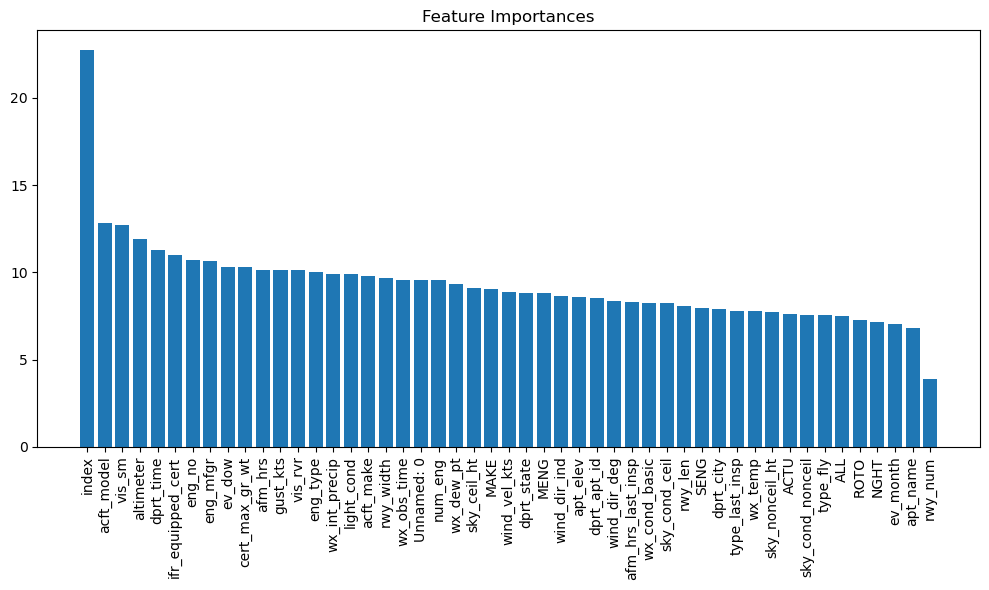

In [79]:
# Get the weights of the neural network
weights = model3.get_weights()

# Calculate the absolute sum of weights for each feature
feature_importances = np.sum(np.abs(weights[0]), axis=1)

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature importance rankings
for i in range(len(feature_importances)):
    print(f"{i + 1}. Feature: {X.columns[indices[i]]}, Importance: {feature_importances[indices[i]]}")



#Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()



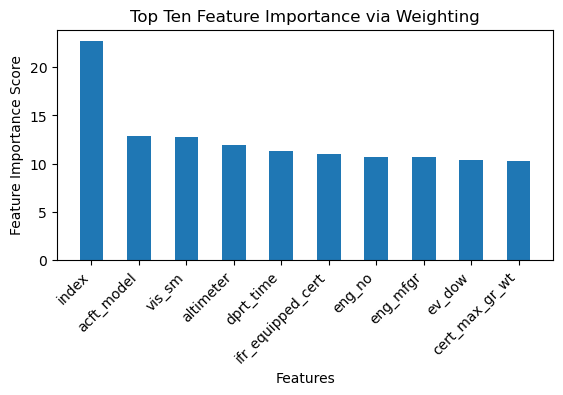

In [81]:
# Sort the feature importance scores and labels in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_scores = feature_importances[sorted_indices]
sorted_labels = np.array(X.columns)[sorted_indices]

# Filter the top ten features
top_indices = sorted_indices[:10]
top_scores = sorted_scores[:10]
top_labels = sorted_labels[:10]

# Define the width and spacing between bars
bar_width = 0.5
bar_spacing = 0.5

# Calculate the positions of the bars
x = np.arange(len(top_scores))
bar_positions = x * (bar_width + bar_spacing)

# Plot the top ten feature importance scores with labels
plt.bar(bar_positions, top_scores, width=bar_width, tick_label=top_labels)

plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title('Top Ten Feature Importance via Weighting')

# Adjust the spacing and rotation of the tick labels
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.4)  # Increase the bottom value for more spacing

plt.show()

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
857/876 [============================>.] - ETA: 0s - loss: 1266382381514752.0000 - accuracy: 0.8965WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f83b7d7ba60> and will run it as-is.
Please report this to the TensorFlow team

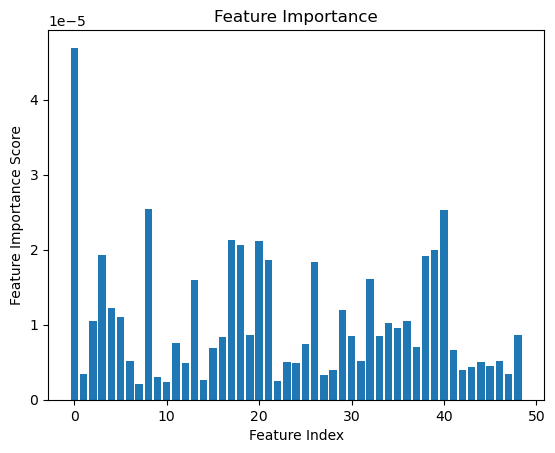

In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Shuffling the data prior to splitting for train/test/val sets
resampled_df_no_index_shuffled = resampled_df_no_index.sample(frac=1).reset_index()

# Split the data into features (X) and target variable (y)
X = resampled_df_no_index_shuffled.drop('target', axis=1)
y = resampled_df_no_index_shuffled['target']

# Train-test split using a stratified method as this experiment is with the unbalanced dataset
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Perform stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Convert the target variables to categorical
num_classes = resampled_df_no_index_shuffled['target'].nunique()  # Set the number of classes
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=num_classes)
y_val_categorical = keras.utils.to_categorical(y_val - 1, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)

# Define your model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile your model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=10)

# Evaluate the model on the test data
y_pred_categorical = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_categorical, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)
accuracy = np.mean(y_pred_labels == y_test_labels)

# Convert the input data to a TensorFlow tensor
X_test_tensor = tf.constant(X_test.values, dtype=tf.float32)

# Compute gradients of the predicted class score with respect to the input features
grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[-1].output)
with tf.GradientTape() as tape:
    tape.watch(X_test_tensor)
    predictions = grad_model(X_test_tensor)
    predicted_class_scores = tf.reduce_sum(predictions * y_pred_categorical, axis=1)
grads = tape.gradient(predicted_class_scores, X_test_tensor)

# Compute feature importance scores as the element-wise absolute mean of gradients
feature_importances = np.mean(np.abs(grads.numpy()), axis=0)

# Print feature importance scores
for i in range(len(feature_importances)):
    print(f"Feature {i}: Importance Score {feature_importances[i]}")

# Plot the feature importance scores
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance')
plt.show()

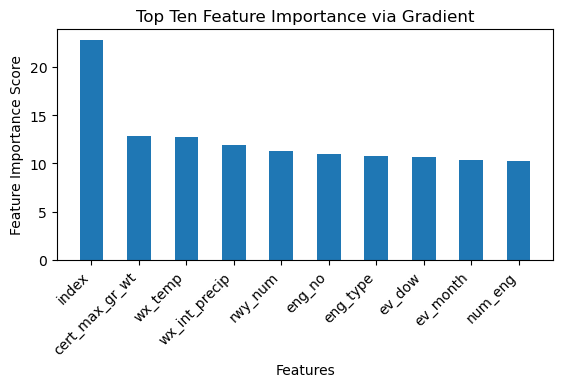

In [82]:
# Sort the feature importance scores and labels in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_scores = feature_importances[sorted_indices]
sorted_labels = np.array(feature_labels)[sorted_indices]

# Filter the top ten features
top_indices = sorted_indices[:10]
top_scores = sorted_scores[:10]
top_labels = sorted_labels[:10]

# Define the width and spacing between bars
bar_width = 0.5
bar_spacing = 0.5

# Calculate the positions of the bars
x = np.arange(len(top_scores))
bar_positions = x * (bar_width + bar_spacing)

# Plot the top ten feature importance scores with labels
plt.bar(bar_positions, top_scores, width=bar_width, tick_label=top_labels)

plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title('Top Ten Feature Importance via Gradient')

# Adjust the spacing and rotation of the tick labels
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.4)  # Increase the bottom value for more spacing

plt.show()
